## Cost Aware Assignment Problem

48929it [01:06, 736.09it/s]


Epoch 0, Average Loss: 1.7953929360070104


48929it [01:05, 744.17it/s]
48929it [01:05, 744.66it/s]
48929it [01:05, 742.47it/s]
48929it [01:05, 745.24it/s]
48929it [01:05, 744.48it/s]
48929it [01:05, 743.85it/s]
48929it [01:05, 742.73it/s]
48929it [01:05, 744.16it/s]
48929it [01:05, 744.45it/s]
48929it [01:05, 743.55it/s]


Epoch 10, Average Loss: 1.72200257094287


48929it [01:05, 744.65it/s]
48929it [01:05, 744.49it/s]
48929it [01:05, 744.68it/s]
48929it [01:05, 744.91it/s]
48929it [01:05, 743.17it/s]
48929it [01:05, 742.11it/s]
48929it [01:06, 737.67it/s]
48929it [01:06, 739.17it/s]
48929it [01:05, 750.57it/s]
48929it [01:05, 751.55it/s]


Epoch 20, Average Loss: 1.7216739752894343


48929it [01:05, 751.34it/s]
48929it [01:05, 751.78it/s]
48929it [01:05, 751.94it/s]
48929it [01:05, 752.10it/s]
48929it [01:05, 747.99it/s]
48929it [01:06, 740.53it/s]
48929it [01:06, 740.59it/s]
48929it [01:06, 739.37it/s]
48929it [01:05, 746.76it/s]


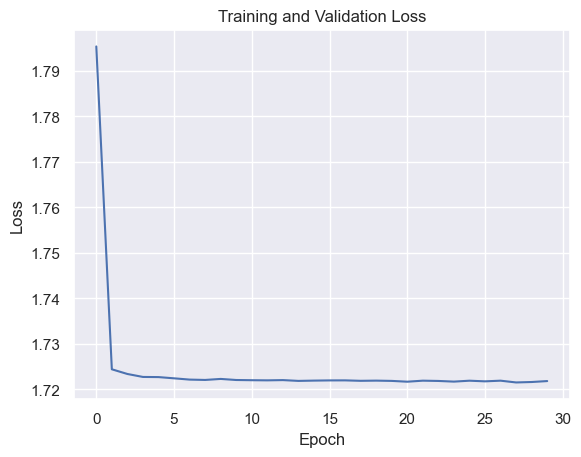

In [13]:
import matplotlib.pyplot as plt
import cost_aware

model, loss_history = cost_aware.get_loss(num_epochs=30)
roi_direct = cost_aware.get_roi(model)

# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### TPM-SL

In [7]:
roi_tpmsl = cost_aware.get_roi_tpmsl()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.002913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992


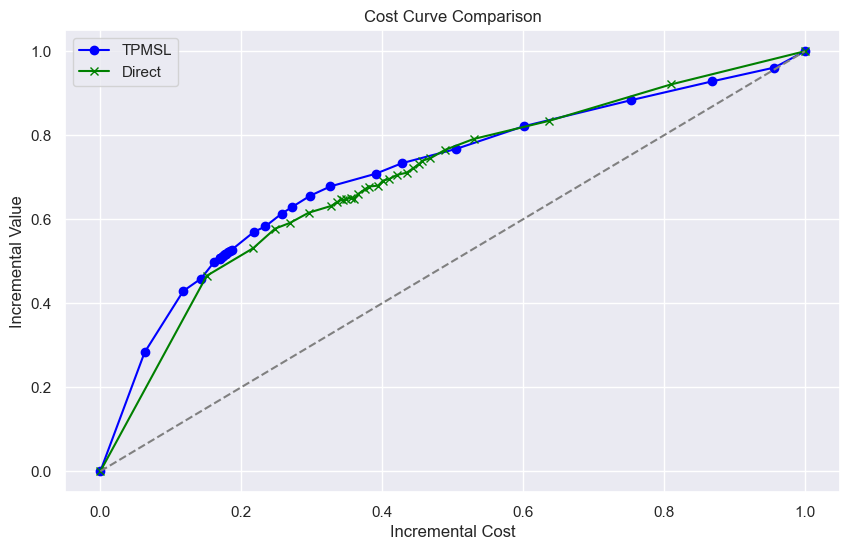

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# 処理を関数化して同じ処理を二回行う

# それぞれのデータセットについて計算
incremental_costs_tpmsl, incremental_values_tpmsl = cost_aware.calculate_values(roi_tpmsl)
incremental_costs_direct, incremental_values_direct = cost_aware.calculate_values(roi_direct)


# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='blue',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='green', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()

## Cost Unaware Treament Assignment Problem

In [27]:
import cost_unaware

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.248699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992


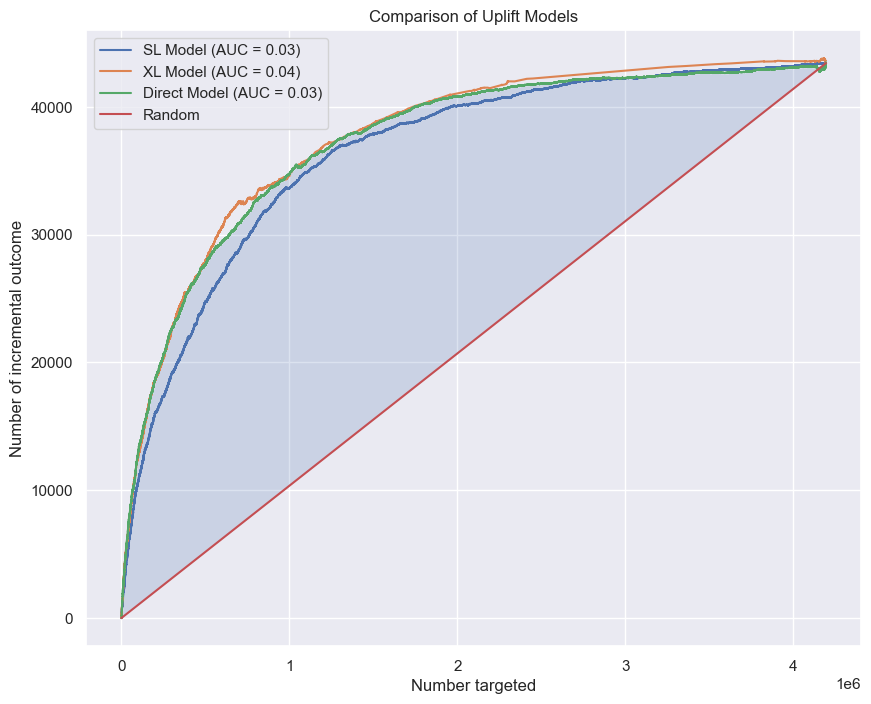

In [30]:
import cost_unaware

tau_direct = cost_unaware.get_tau_direct()
tau_sl = cost_unaware.get_tau_sl()
tau_xl = cost_unaware.get_tau_xl()

cost_unaware.uplift(tau_direct, tau_sl, tau_xl)

### Causal Forest

In [16]:
# # causal forest での効果の推定
# from econml.dml import CausalForestDML
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from statsmodels.nonparametric.kernel_regression import KernelReg

# # モデルの構築
# cf = CausalForestDML(model_y=LinearRegression(),
#                      model_t=LogisticRegression(),
#                      discrete_treatment=True,
#                      n_estimators=4)
# cf.fit(y_train, T_train, X=X_train)

# # 効果の推定
# tau_cf = cf.effect(X_test)

### 提案手法

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

# データをテンソルに変換
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
# T_val_tensor = torch.tensor(T_val.values, dtype=torch.float32)

# データをテンソルに変換してDatasetを作成
dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_train_tensor[T_train_tensor == 1])
dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_train_tensor[T_train_tensor == 0])
# dataset_1_val = TensorDataset(X_val_tensor[T_val_tensor == 1], y_val_tensor[T_val_tensor == 1])
# dataset_0_val = TensorDataset(X_val_tensor[T_val_tensor == 0], y_val_tensor[T_val_tensor == 0])

# DataLoaderの定義
loader_1 = DataLoader(dataset_1, batch_size=340, shuffle=True)
loader_0 = DataLoader(dataset_0, batch_size=0, shuffle=True)
# loader_1_val = DataLoader(dataset_1_val, batch_size=170, shuffle=True)
# loader_0_val = DataLoader(dataset_0_val, batch_size=30, shuffle=True)

# 非線形モデルの定義
class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 36)
        # self.dropout1 = nn.Dropout(0.1) 
        self.fc2 = nn.Linear(36, 18)
        # self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(18, 6)
        # self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(6, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)  # Dropoutを適用
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x) 
        x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        # 恒等関数を適用
        x = self.fc4(x)

        return x


# model = LogisticRegressionModel(X_train_tensor.shape[1])
model = NonLinearModel(X_train_tensor.shape[1])

# 損失関数の定義
def custom_loss(y, q, group_size):
    # qが0になるのを防ぐ
    q = torch.clamp(q, 1e-8, 1 - 1e-8)

    # 損失計算
    loss = -torch.sum(y * torch.log(q)) / group_size
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.001)
# 1. LambdaLR
# lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history, loss_history_val = [], []  # 損失を記録するリストを初期化

for (x_1, y_1), (x_0, y_0) in tqdm(zip(loader_1, loader_0)):
    optimizer.zero_grad()
    
    s_1 = model(x_1)
    s_0 = model(x_0)

    q_1 = torch.softmax(s_1, dim=0)
    q_0 = torch.softmax(s_0, dim=0)

    loss_1 = custom_loss(y_1, q_1, x_1.size(0))
    loss_0 = custom_loss(y_0, q_0, x_0.size(0))
    
    loss = loss_1 - loss_0
    # 1回だけlossをprint
    # if count_batches == 0:
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    loss.backward()
    optimizer.step()

    total_loss += loss.item()  # 総損失に今回のバッチの損失を加算
    count_batches += 1

average_loss = total_loss / count_batches  # このエポックの平均損失
loss_history.append(average_loss)  # 損失履歴に追加
# 学習率のスケジューラを更新
# lambda_scheduler.step()

# 検証データでの損失を計算
# model.eval()
# total_val_loss = 0
# count_val_batches = 0
# with torch.no_grad():
#     for (x_1_val, y_r_1_val, y_c_1_val), (x_0_val, y_r_0_val, y_c_0_val) in zip(loader_1_val, loader_0_val):
#         q_1_val = model(x_1_val)
#         q_0_val = model(x_0_val)
        
#         loss_1_val = custom_loss(y_r_1_val, y_c_1_val, q_1_val, x_1_val.size(0))
#         loss_0_val = custom_loss(y_r_0_val, y_c_0_val, q_0_val, x_0_val.size(0))
        
#         loss_val = loss_1_val - loss_0_val
#         total_val_loss += loss_val.item()
#         count_val_batches += 1

# average_val_loss = total_val_loss / count_val_batches
# loss_history_val.append(average_val_loss)


if epoch % 1 == 0:
    print(f'Epoch {epoch}, Average Loss: {average_loss}')


24465it [00:45, 532.57it/s]


Epoch 0, Average Loss: 86.81520851469712


24465it [00:49, 490.11it/s]


Epoch 1, Average Loss: 86.81521098703882


24465it [00:51, 478.43it/s]


Epoch 2, Average Loss: 86.81541175616195


24465it [00:49, 490.10it/s]


Epoch 3, Average Loss: 86.81530524619683


24465it [00:50, 488.56it/s]


Epoch 4, Average Loss: 86.81525368521898


24465it [00:50, 484.80it/s]


Epoch 5, Average Loss: 86.81535796339517


24465it [00:50, 484.76it/s]


Epoch 6, Average Loss: 86.81525590574232


24465it [00:50, 483.27it/s]


Epoch 7, Average Loss: 86.81535754820673


24465it [00:51, 478.56it/s]


Epoch 8, Average Loss: 86.81525249843726


24465it [00:51, 477.36it/s]


Epoch 9, Average Loss: 86.81515065668162


24465it [00:49, 491.01it/s]


Epoch 10, Average Loss: 86.81545895479609


24465it [00:52, 467.12it/s]


Epoch 11, Average Loss: 86.81535398411941


24465it [00:54, 452.33it/s]


Epoch 12, Average Loss: 86.81530312546528


13301it [00:29, 453.95it/s]


KeyboardInterrupt: 

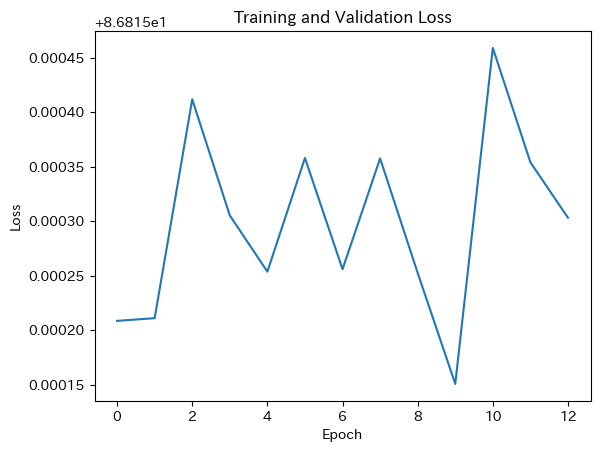

In [83]:
# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 評価
model.eval()
with torch.no_grad():
    q_test = model(torch.tensor(X_test.values, dtype=torch.float32))
    tau_direct = q_test.numpy() / np.sum(q_test.numpy())